In [2]:
%pip install nltk wordcloud xgboost lightgbm catboost 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip uninstall leia-br -y
%pip install leia-br

Found existing installation: leia-br 0.0.1
Uninstalling leia-br-0.0.1:
  Successfully uninstalled leia-br-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Using cached leia_br-0.0.1-py2.py3-none-any.whl.metadata (2.9 kB)
Using cached leia_br-0.0.1-py2.py3-none-any.whl (130 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import os
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Text Processing Libraries
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
from nltk import ngrams

# Sentiment Analysis
from LeIA import SentimentIntensityAnalyzer

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Machine Learning Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report, 
    confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, auc
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mumu1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mumu1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
from IPython.core.display import HTML
HTML('''<style>
div.output_area {
    max-height: none !important;
}
</style>''')

# 출력 제한 완전히 제거
get_ipython().run_line_magic('config', "InlineBackend.print_figure_kwargs = {'bbox_inches': None}") 

In [6]:
from RFM import df_order_reviews, df_product_category_name_translation, df_products, merge_coi

# Merging

In [7]:
# 1) 전체 분석 review_comment_message, product_category_name, order_id
# 2) 이탈고객 vs 잠재우수 고객

df_reviews = df_order_reviews[['order_id', 'review_comment_message']]

# merge_coi + df_products = NLP
NLP = merge_coi.merge(
    df_products[['product_id', 'product_category_name']],  
    on='product_id',
    how='inner'
)

# NLP + df_reviews = NLP
NLP = NLP.merge(
    df_reviews[['order_id', 'review_comment_message']], 
    on='order_id',
    how='inner'
)


# Data cleaning

In [8]:
# 데이터 선택 및 기본 정제
clean_NLP = NLP[['order_id', 'review_comment_message', 'product_category_name']]

# 결측치 제거
clean_NLP = clean_NLP.dropna(subset=['product_category_name', 'review_comment_message'])

# 중복 제거
clean_NLP = clean_NLP.drop_duplicates(subset=['review_comment_message']).reset_index(drop=True)

clean_NLP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33495 entries, 0 to 33494
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   order_id                33495 non-null  object
 1   review_comment_message  33495 non-null  object
 2   product_category_name   33495 non-null  object
dtypes: object(3)
memory usage: 785.2+ KB


# text preprocessing

In [12]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode

# 1. 불용어 설정 
STOP_WORDS = set(stopwords.words('portuguese')) | {
    'dia', 'bom', 'fiz', 'td', 'q', 'mim', 'bem', 'ainda', 'tudo',
    'ra', 'sa', 'ter', 'sido', 'veio', 'vai', 'fazer', 'assim',
    'ate', 'pra', 'pro', 'pela', 'pelo', 'tbm', 'vc', 'eh'
}

# 2. 전처리 함수 
def simple_clean(text):
    if not isinstance(text, str): return ""
    
    # 소문자 변환 -> 유니코드 정규화(accent 제거) -> 알파벳 제외한 모든 문자(숫자, 특수문자) 공백 치환
    text = re.sub(r'[^a-z\s]', ' ', unidecode(text.lower()))
    
    # 불용어 제거 및 2글자 이상만 남기기
    return " ".join([w for w in text.split() if w not in STOP_WORDS and len(w) > 1])

# 3. 데이터프레임 적용(결측치만 제거)
clean_NLP = clean_NLP.dropna(subset=['review_comment_message']).copy()

# 텍스트 정제 적용
clean_NLP['review_comment_message_clean'] = clean_NLP['review_comment_message'].apply(simple_clean)

# 빈 결과 제거 (전처리 후 내용이 다 사라진 경우)
clean_NLP = clean_NLP[clean_NLP['review_comment_message_clean'] != ""]

# 토큰화 컬럼 생성
clean_NLP['review_comment_message_tokens'] = clean_NLP['review_comment_message_clean'].str.split()

# 결과 확인
print(clean_NLP[['review_comment_message', 'review_comment_message_clean', 'review_comment_message_tokens']].head())

                           review_comment_message  \
0  O baratheon Ã¨ esxelente Amo adoro o baratheon   
1                               Loja responsÃ¡vel   
2                       chegou antes do prometido   
3        Ã³timo, entregou antes da data prevista.   
4            Td certo.Produto e prazo de entrega.   

              review_comment_message_clean  \
0  baratheon esxelente amo adoro baratheon   
1                        loja responsa vel   
2                   chegou antes prometido   
3        timo entregou antes data prevista   
4              certo produto prazo entrega   

                   review_comment_message_tokens  
0  [baratheon, esxelente, amo, adoro, baratheon]  
1                          [loja, responsa, vel]  
2                     [chegou, antes, prometido]  
3        [timo, entregou, antes, data, prevista]  
4               [certo, produto, prazo, entrega]  



# `SentimentIntensityAnalyzer` in LeIA

In [13]:
# Initialize the Sentiment Analyzer once
analyzer = SentimentIntensityAnalyzer()

def classify_sentiment(df, column_name='review_comment_message_clean'):
    # Vectorized function to get sentiment classification
    def get_sentiment_classification(text):
        scores = analyzer.polarity_scores(text)
        if scores['compound'] >= 0.05:
            return 'Positive'
        elif scores['compound'] <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'
    
    # Apply sentiment analysis using map for faster iteration
    df[f'{column_name}_sentiment'] = df[column_name].map(get_sentiment_classification)
    return df

# Classify sentiment in 'clean_NLP' based on the 'review_comment_message_clean' column
clean_NLP = classify_sentiment(clean_NLP, 'review_comment_message_clean')

# Display the sentiment results
clean_NLP[['review_comment_message_clean', 'review_comment_message_clean_sentiment']].head(25)

,review_comment_message_clean,review_comment_message_clean_sentiment
0,baratheon esxelente amo adoro baratheon,Neutral
1,loja responsa vel,Neutral
2,chegou antes prometido,Positive
3,timo entregou antes data prevista,Neutral
4,certo produto prazo entrega,Positive
5,pena produto entregue casa retirar correios,Negative
6,produto chegou prazo problema frente capa dani...,Negative
7,ameiiii excelente produto excelente qualidade ...,Positive
8,produto chegou antes data prevista,Neutral
9,compra pea entregarou caixa violada,Neutral


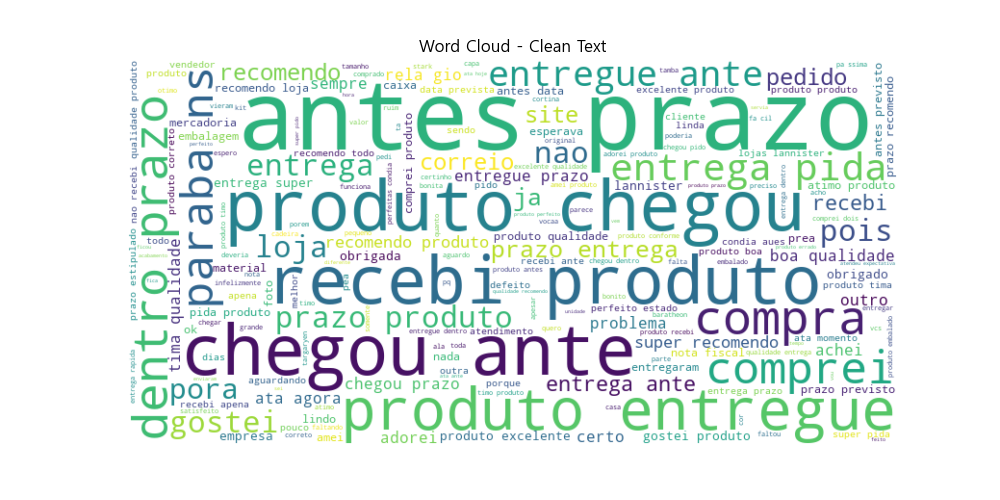

In [14]:
# Concatenate all non-null texts from the 'cleaned_text' column into a single string
text_combined = " ".join(clean_NLP['review_comment_message_clean'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_combined)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud - Clean Text")
plt.axis("off")  # Remove the axes
plt.show()

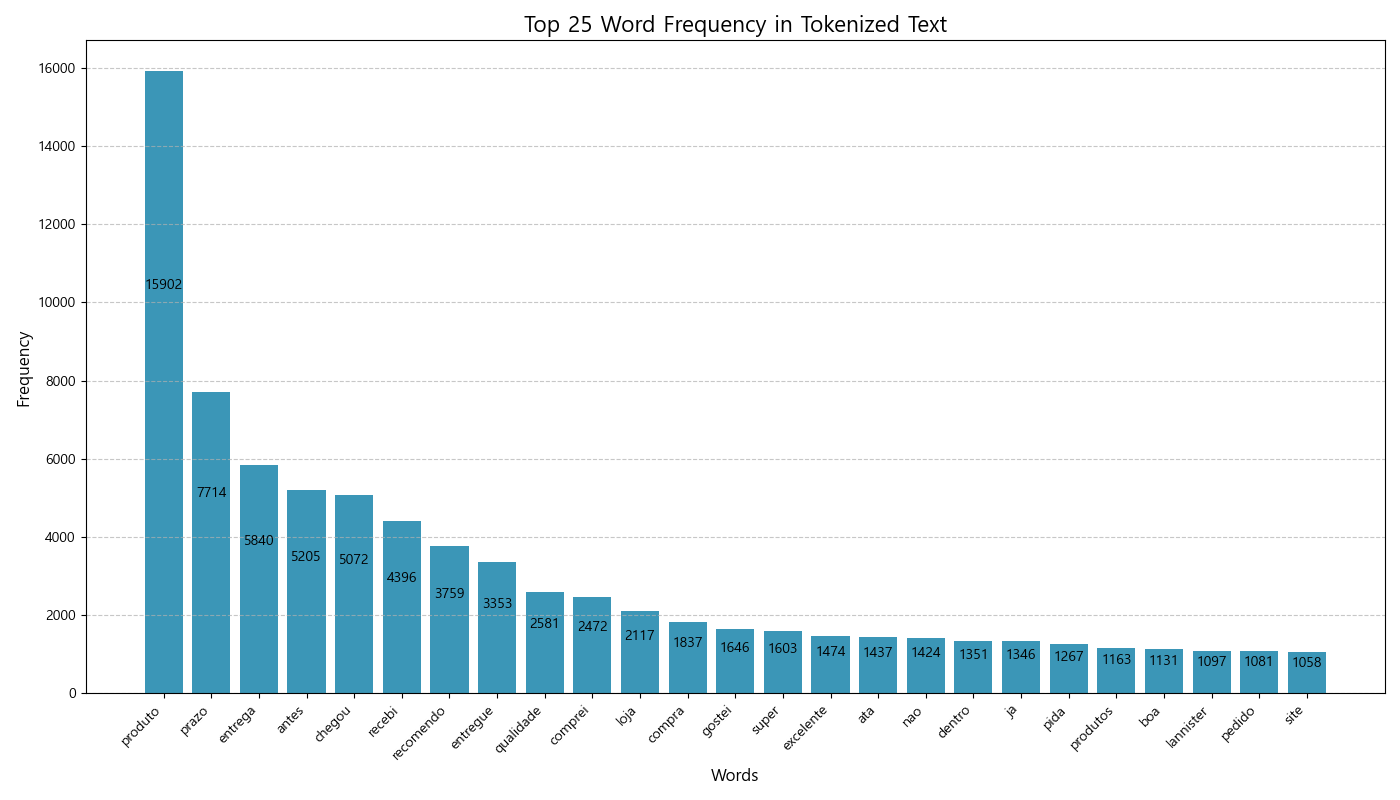

In [15]:
#EDA
# Function to get top N tokens or n-grams
def get_top_tokens(clean_NLP, token_column='review_comment_message_tokens', top_n=50):
    all_tokens = [token for tokens in clean_NLP[token_column] for token in tokens]
    token_counts = Counter(all_tokens)
    return token_counts.most_common(top_n)

# Function to create a DataFrame from frequency counts
def create_frequency_df(counter, columns=['Word', 'Frequency']):
    return pd.DataFrame(counter.items(), columns=columns)

# General plotting function for bar charts
def plot_top_frequencies(clean_NLP, title, xlabel, column_name):
    plt.figure(figsize=(14, 8))
    bars = plt.bar(clean_NLP[column_name], clean_NLP['Frequency'], color='#3b96b7')
    
    # Add labels
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2., bar.get_height() - max(5, bar.get_height() * 0.35), 
                 f'{int(bar.get_height())}', ha='center', color='black', fontsize=10)

    # Customize and show plot
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Get top tokens and plot
top_50_tokens = get_top_tokens(clean_NLP, 'review_comment_message_tokens', 50)
top_50_tokens_df = create_frequency_df(dict(top_50_tokens))
plot_top_frequencies(top_50_tokens_df.head(25), 'Top 25 Word Frequency in Tokenized Text', 'Words', 'Word')

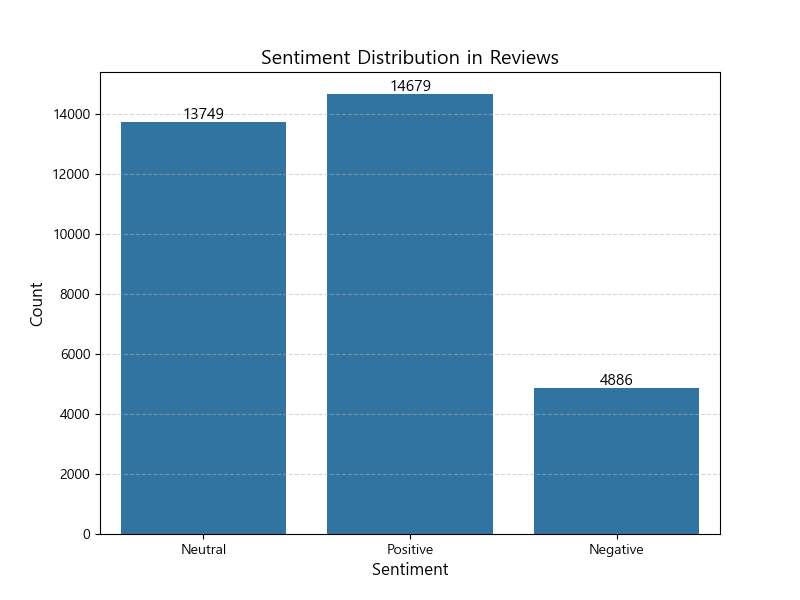

In [16]:
# Plot the sentiment count
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="review_comment_message_clean_sentiment", data=clean_NLP)

# Add labels and title
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Sentiment Distribution in Reviews", fontsize=14)

# Display value labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Reduce gridline visibility for a cleaner look
plt.grid(visible=True, axis='y', linestyle='--', alpha=0.5)

plt.show()

In [18]:
clean_NLP.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33314 entries, 0 to 33494
Data columns (total 6 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   order_id                                33314 non-null  object
 1   review_comment_message                  33314 non-null  object
 2   product_category_name                   33314 non-null  object
 3   review_comment_message_clean            33314 non-null  object
 4   review_comment_message_tokens           33314 non-null  object
 5   review_comment_message_clean_sentiment  33314 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


# Data Preprocessing

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. 데이터 준비
X = clean_NLP['review_comment_message']
y = clean_NLP['review_comment_message_clean_sentiment']

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  
)

# 3. Label Encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 확인: 실제 어떤 숫자가 어떤 감성인지 매핑 확인 (중요)
for index, label in enumerate(label_encoder.classes_):
    print(f"숫자 {index} = {label}")

# 4. TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test) # Test셋은 fit 하지 않고 transform만!

# 5. 메모리 체크
print(f"Train Matrix Shape: {X_train_tfidf.shape}")

숫자 0 = Negative
숫자 1 = Neutral
숫자 2 = Positive
Train Matrix Shape: (26651, 5000)
